In [1]:
import pandas as pd
import numpy as np
import talib as tl
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow import keras

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import display

## 0 Load Data & Config

In [2]:
class global_config:
    stock_ticker = 'MS'
    stock_ticker_x = 'GS'
    etf_ticker = 'GDX'
    etf_ticker_x = 'UGL'
    new_feature = True
    lag_period =  1

class stock_config:
    seq_len =28
    batch_size = 32
    epochs=20
    loss='mean_squared_error'
    optimizer='Adam'           
    learning_rate= 5e-5
    val_split=0
    test_split=0.1

class etf_config:
    seq_len = 28
    batch_size = 64
    epochs=20
    loss='mean_squared_error'
    optimizer='Adam'
    learning_rate= 1e-4
    val_split=0
    test_split=0.3

# set seeds
tf.keras.utils.set_random_seed(666)

In [3]:
df_price_etf_pair = pd.read_csv(f"./data/df_etfs_market_data_pairs.csv", index_col=0)
df_price_stock_pair = pd.read_csv(f"./data/df_stocks_market_data_pairs.csv", index_col=0)

# clean data
df_price_etf = df_price_etf_pair.query(f"symbol=='{global_config.etf_ticker}'").set_index('datetime').drop(columns=['Close','symbol'])
df_price_etf_x = df_price_etf_pair.query(f"symbol=='{global_config.etf_ticker_x}'").set_index('datetime').drop(columns=['Close','symbol'])

df_price_stock = df_price_stock_pair.query(f"symbol=='{global_config.stock_ticker}'").set_index('datetime').drop(columns=['Close','symbol'])
df_price_stock_x = df_price_stock_pair.query(f"symbol=='{global_config.stock_ticker_x}'").set_index('datetime').drop(columns=['Close','symbol'])

## 1 Feature Engineering
- Generate label.
- Add TA factors.
- Split the dataset.
- Scale the data

In [4]:
class LabelGenerator:
    def __init__(self, df_data, price_type='close', lag=1):
        self.df_data = df_data
        self.price_type = price_type
        self.lag = lag
        self.df_x = None
        self.df_y = None

    def generate_label(self):
        self.df_y = self.df_data[self.price_type].shift(-self.lag).ffill()

    def run(self):
        self.generate_label()
        self.df_x = self.df_data

stock_label_generator = LabelGenerator(df_price_stock, price_type='close', lag=global_config.lag_period)
stock_label_generator.run()
etf_label_generator = LabelGenerator(df_price_etf, price_type='close', lag=global_config.lag_period)
etf_label_generator.run()

df_x_stock, df_y_stock = stock_label_generator.df_x, stock_label_generator.df_y
df_x_etf, df_y_etf = etf_label_generator.df_x, etf_label_generator.df_y

In [5]:
class TechFactorsCalculator:
    def __init__(self, df_data, new_feature=True):
        self.df_data = df_data
        self.new_feature = new_feature
        self.close = df_data['close']
        self.open = df_data['open']
        self.high = df_data['high']
        self.low = df_data['low']
        self.volume = df_data['volume']
        self.date = df_data.index
    
    def clean_data(self):
        self.df_data = self.df_data.ffill().bfill()
        
    def run(self):
        if not self.new_feature:
            return
        
        self.df_data['BBANDS_upperband'], self.df_data['BBANDS_middleband'], self.df_data['BBANDS_lowerband'] = tl.BBANDS(self.close, timeperiod=5, nbdevup=2, nbdevdn=2,
                                                matype=0)  
        self.df_data['EMA'] = tl.EMA(self.close, timeperiod=30) 
        self.df_data['SMA'] = tl.SMA(self.close, timeperiod=30) 
        self.df_data['TRIMA'] = tl.TRIMA(self.close, timeperiod=30)
        
        self.df_data['ATR'] = tl.ATR(self.high, self.low, self.close, timeperiod=14)  # Volatility Indicators

        self.df_data['ADX'] = tl.ADX(self.high, self.low, self.close, timeperiod=14)  # Momentum Indicators

        self.df_data['MACD_macd'], self.df_data['MACD_macdsignal'], self.df_data['MACD_macdhist'] = tl.MACD(self.close, fastperiod=12, slowperiod=26,
                                          signalperiod=9)  # Momentum Indicators
        self.clean_data()

In [6]:
# add new features or not
tech_factors_calculator_stock = TechFactorsCalculator(df_x_stock, new_feature=global_config.new_feature)
tech_factors_calculator_stock.run()
df_featured_stock = tech_factors_calculator_stock.df_data

tech_factors_calculator_stock = TechFactorsCalculator(df_price_stock_x, new_feature=global_config.new_feature)
tech_factors_calculator_stock.run()
df_featured_stock_x = tech_factors_calculator_stock.df_data
df_featured_stock = pd.merge(df_featured_stock, df_featured_stock_x, on='datetime')

tech_factors_calculator_etf = TechFactorsCalculator(df_x_etf, new_feature=global_config.new_feature)
tech_factors_calculator_etf.run()
df_featured_etf = tech_factors_calculator_etf.df_data

tech_factors_calculator_etf = TechFactorsCalculator(df_price_etf_x, new_feature=global_config.new_feature)
tech_factors_calculator_etf.run()
df_featured_etf_x = tech_factors_calculator_etf.df_data
df_featured_etf = pd.merge(df_featured_etf, df_featured_etf_x, on='datetime')

In [7]:
# split dataset
x_train_stock, x_test_stock, y_train_stock, y_test_stock = train_test_split(df_featured_stock,df_y_stock,test_size=stock_config.test_split,shuffle=False)
x_train_etf, x_test_etf, y_train_etf, y_test_etf = train_test_split(df_featured_etf,df_y_etf,test_size=etf_config.test_split,shuffle=False)

In [8]:
# add scaler, scale all the data

scaler_stock = StandardScaler()
scaler_etf = StandardScaler()

scaler_stock.fit(x_train_stock)
scaler_etf.fit(x_train_etf)

x_train_stock, x_test_stock = scaler_stock.transform(x_train_stock), scaler_stock.transform(x_test_stock)
x_train_etf, x_test_etf = scaler_etf.transform(x_train_etf), scaler_etf.transform(x_test_etf)

In [9]:
# create sequential data for input into LSTM
def create_sequential_data(X_train, X_test, y_train, y_test, seq_len):
    train_input = []
    train_output = []
    test_input = []
    test_output = []

    for i in range(seq_len-1, len(X_train)-1):
        train_input.append(X_train[i+1-seq_len:i+1])
        train_output.append(y_train[i])

    for j in range(seq_len-1, len(X_test)-1):
        test_input.append(X_test[j+1-seq_len:j+1])
        test_output.append(y_test[j])

    train_x = np.array(train_input)
    train_y = np.array(train_output)
    test_x = np.array(test_input)
    test_y = np.array(test_output)

    return train_x,train_y,test_x,test_y

In [10]:
 # reshape dataset
train_x_stock,train_y_stock,test_x_stock,test_y_stock = create_sequential_data(x_train_stock, x_test_stock, y_train_stock, y_test_stock, stock_config.seq_len)

train_x_etf,train_y_etf,test_x_etf,test_y_etf = create_sequential_data(x_train_etf, x_test_etf, y_train_etf, y_test_etf, etf_config.seq_len)

## 2 Train Model
- Train the model

In [11]:
def build_model_stock():
    model = Sequential()

    model.add(LSTM(input_shape=(stock_config.seq_len,train_x_stock.shape[-1]), units=64, return_sequences=True, dropout=0.2, name='LSTM1'))
    model.add(LSTM(128, return_sequences=False, name='LSTM2'))
    model.add(Dense(512, name='Dense1'))
    model.add(Dropout(0.3, name='Dropout1'))
    model.add(Dense(128, name='Dense2'))
    model.add(Dense(units=1, name='Dense3'))


    model.compile(loss=stock_config.loss, optimizer=Adam(learning_rate=stock_config.learning_rate))
    print(model.summary())

    return model

def build_model_etf():
    model = Sequential()

    model.add(LSTM(input_shape=(etf_config.seq_len,train_x_etf.shape[-1]), units=64, return_sequences=True, dropout=0.2, name='LSTM1'))
    model.add(LSTM(256, return_sequences=False, name='LSTM2'))
    model.add(Dense(512, name='Dense1'))
    model.add(Dense(256, name='Dense2'))
    model.add(Dense(128, name='Dense3'))
    model.add(Dense(units=1, name='Dense4'))


    model.compile(loss=etf_config.loss, optimizer=Adam(learning_rate=stock_config.learning_rate))
    print(model.summary())

    return model

In [12]:
def train_model(model, train_x, train_y, asset='stock'):
    ## add tensorboard call back

    log_dir = f"./logs/{asset}/featured" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    if asset == 'stock':
        history = model.fit(train_x, train_y, batch_size=stock_config.batch_size, epochs=stock_config.epochs,
                                  validation_split=stock_config.val_split, callbacks=[tensorboard_callback])
    elif asset == 'etf':
        history = model.fit(train_x, train_y, batch_size=etf_config.batch_size, epochs=etf_config.epochs,
                                  validation_split=etf_config.val_split, callbacks=[tensorboard_callback])
    return history, model

In [29]:
# train model on stock
# model_stock = build_model_stock()
# model_history_stock, model_stock_trained = train_model(model_stock, train_x_stock, train_y_stock, asset='stock')
model_stock_trained = keras.saving.load_model("./models/featured_stock_model_v1")

In [31]:
# train model on etf
# model_etf = build_model_etf()
# model_history_etf, model_etf_trained = train_model(model_etf, train_x_etf, train_y_etf, asset='etf')
model_etf_trained = keras.saving.load_model("./models/featured_etf_model_v1")

## 3 Evaluate Model

In [35]:
def plot_prediction(pred_series, test_series, label=''):
    # plot charts
    plt.figure(figsize=(8,4))
    plt.title(f"Model Prediction On {label} Set")
    plt.plot(pred_series, label='pred')
    plt.plot(test_series, label='real')
    plt.legend()
    plt.show()

def evaluate_model(model, train_x, train_y, test_x, test_y):
    pred_results_train = model.predict(train_x)
    pred_results_test = model.predict(test_x)

    # TODO plot tables
    mae_train = mean_absolute_error(train_y, pred_results_train)
    mse_train = mean_squared_error(train_y, pred_results_train)
    r2_train = r2_score(train_y, pred_results_train)

    mae_test = mean_absolute_error(test_y, pred_results_test)
    mse_test = mean_squared_error(test_y, pred_results_test)
    r2_test = r2_score(test_y, pred_results_test)

    model_performance_table = pd.DataFrame([[mae_train, mse_train, r2_train], [mae_test, mse_test, r2_test]]
                                           , index=['Train', 'Test'], columns=['MAE', 'MSE', 'R^2']).T
    display(model_performance_table)

    # plot charts
    plot_prediction(pred_results_train, train_y, label='Train')
    plot_prediction(pred_results_test, test_y, label='Test')

    return model_performance_table

7/7 [==============================] - 0s 8ms/step


,Train,Test
MAE,1.519490,3.875249
MSE,4.380627,24.173596
R^2,0.989957,0.361897


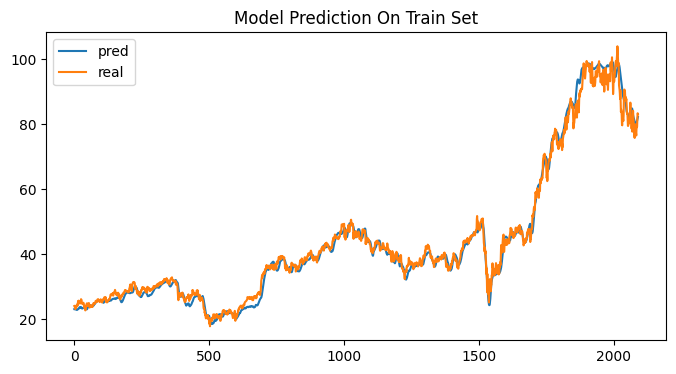

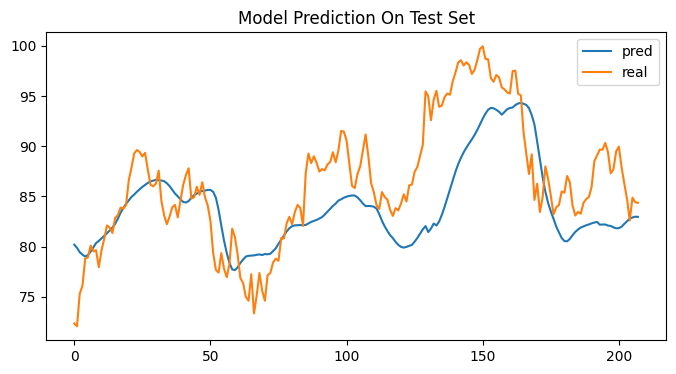

In [36]:
# evaluate model on stock
model_performance_table = evaluate_model(model_stock_trained, train_x_stock,train_y_stock,test_x_stock,test_y_stock )
# model_stock_trained.save(f"./featured_stock_model_v1")
model_performance_table.to_csv(f"./results/stock_featured_prediction_performance.csv")

22/22 [==============================] - 0s 9ms/step


,Train,Test
MAE,0.794925,2.349173
MSE,1.124909,9.585919
R^2,0.943737,0.454899


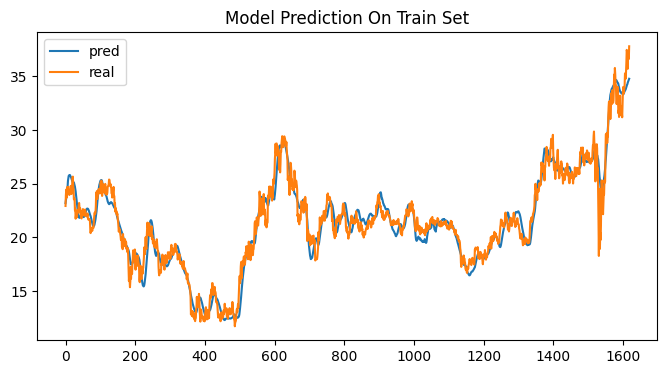

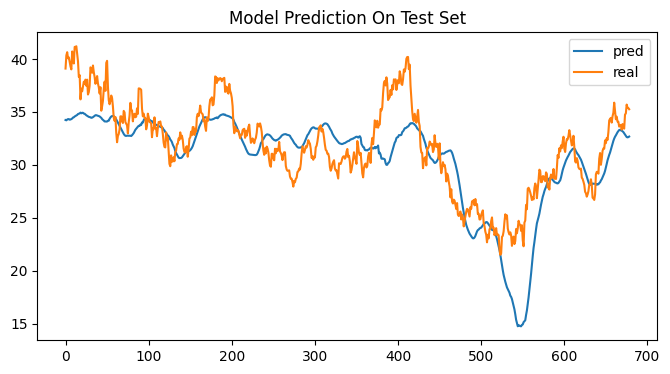

In [37]:
# evaluate model on ETF
model_performance_table = evaluate_model(model_etf_trained, train_x_etf,train_y_etf,test_x_etf,test_y_etf)
# model_etf_trained.save(f"./featured_etf_model_v2")
model_performance_table.to_csv(f"./results/etf_featured_prediction_performance.csv")